#Config

In [0]:
!pip install transformers==2.6.0

     |████████████████████████████████| 542kB 4.9MB/s 
     |████████████████████████████████| 3.7MB 22.9MB/s 
     |████████████████████████████████| 1.1MB 44.8MB/s 
     |████████████████████████████████| 890kB 21.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ed9e2a7f5c7a90c8e4b0659143e838f409f8ee998acfb29299e53fefcc761287
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
!pip install fairseq

     |████████████████████████████████| 307kB 4.7MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035354 sha256=6b340016bf721f682161484d2f73dbdb178981c5b39302e2b3fcda4da0cfff3f
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [0]:
!pip install fastBPE

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=479265 sha256=b128e7deab499fdf81cde93603f13a724d15c73c302c80e1d8cd2c942eb6de53
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [0]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=bf62c637038b6e61d67e75033a745bf8b185cb8253400d3be5c6f62c9e05594e
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import transformers
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler
from torch.nn import CrossEntropyLoss

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from transformers import RobertaConfig, RobertaForTokenClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from seqeval.metrics import f1_score

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MAX_LEN = 60
batch_sz = 16
epochs = 5
max_grad_norm = 1.0

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('{}: {}'.format(device, n_gpu))

cuda: 1


#Load Data


**Read Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/data/ner_products_bio.csv', header=None,
                   sep='\t', encoding='utf8', names=['Sentence#', 'Word', 'Tag'])
data.head(10)

,Sentence#,Word,Tag
0,1,Nhưng,O
1,1,hiện_tại,O
2,1,bạn,O
3,1,đang,O
4,1,cho,O
5,1,bé,O
6,1,bú,O
7,1,nên,O
8,1,bạn,O
9,1,không,O


In [0]:
tuple_func = lambda f: [(w, t) for w, t in zip(f['Word'].values, f['Tag'].values)]
sentences_with_tag = data.groupby('Sentence#').apply(tuple_func)
print(sentences_with_tag)
sentences_with_tag = [sent for sent in sentences_with_tag]

Sentence#
1       [(Nhưng, O), (hiện_tại, O), (bạn, O), (đang, O...
2                        [(Áo, B-pr), (Hm, I-pr), (ạ, O)]
3       [(Cho, O), (mình, O), (đặt, O), (cái, O), (bal...
4       [(Ac, O), (có, O), (vest, B-pr), (chưa, O), (?...
5       [(body, B-pr), (lotion, I-pr), (e, O), (lại, O...
                              ...                        
2949    [(hiện_tại, O), (ở, O), (thành_phố, O), (cao_l...
2950    [(10, B-pr), (+, I-pr), (có, O), (hỗ_trợ, O), ...
2951    [(Tôi, O), (có, O), (mua, O), (1, O), (note, B...
2952    [(Mình, O), (có, O), (samsung, B-pr), (S7edge,...
2953    [(Ad, O), (cko, B-pr), (hoi, O), (gia, O), (hi...
Length: 2952, dtype: object


In [0]:
sentences = [' '.join([word[0] for word in sent]) for sent in sentences_with_tag]
sentences[1]

'Áo Hm ạ'

In [0]:
labels = [[word[1] for word in sent] for sent in sentences_with_tag]
labels[1]

['B-pr', 'I-pr', 'O']

In [0]:
labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
label2idx = {label:indx for indx, label in enumerate(labels_value)}
label2idx

{'B-pr': 0, 'I-pr': 1, 'O': 2, 'PAD': 3, 'X': 6, '[CLS]': 4, '[SEP]': 5}

***Encode with bpe***

In [0]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()

bpe = fastBPE(args)

In [0]:
subwords = ['<s> '+bpe.encode(sent)+' </s>' for sent in sentences]
subwords[1] 

'<s> Áo H@@ m ạ </s>'

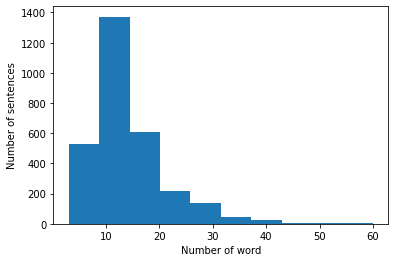

In [0]:
plt.hist([len(s.split()) for s in subwords])
plt.xlabel('Number of word')
plt.ylabel('Number of sentences')
plt.show()

***Change labels by subword***

In [0]:
label_subwords = []
for i in range(len(subwords)):
  indx = 0
  label = ['[CLS]']
  for word in subwords[i].split()[1:MAX_LEN-1]:
    if word == '</s>':
      break
    if '@@' not in word:
      label.append(labels[i][indx])
      indx += 1
      continue
    label.append('X')
  label.append('[SEP]')
  label_subwords.append(label) 
      

In [0]:
label_subwords[1]

['[CLS]', 'B-pr', 'X', 'I-pr', 'O', '[SEP]']

***String to number***

In [0]:
vocab = Dictionary()
vocab.add_from_file("/content/drive/My Drive/pre_model/phobert/PhoBERT_large_transformers/dict.txt")

In [0]:
input_ids = pad_sequences([vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist() for sent in subwords],
                          truncating='post', padding='post', maxlen=MAX_LEN, value=1.0, dtype='long')

In [0]:
input_ids[1]

array([   0, 3759, 1125,  599, 3628,    2,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1])

In [0]:
labels_ids = pad_sequences([[label2idx.get(label) for label in labels] for labels in label_subwords], dtype='long',
                            maxlen=MAX_LEN, value=label2idx['PAD'], truncating='post', padding='post')
labels_ids[1]

array([4, 0, 6, 1, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [0]:
attenion_mask = [[float(val != 1) for val in sent] for sent in input_ids]

***Create train/validation data***

In [0]:
X_test = input_ids[2592:]
y_test = labels_ids[2592:]
test_mask = attenion_mask[2592:]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(input_ids[:2592], labels_ids[:2592], random_state=96, test_size=0.2)
train_mask, val_mask, _, _ = train_test_split(attenion_mask[:2592], input_ids[:2592], random_state=96, test_size=0.2)

In [0]:
# change to tensor
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(val_mask)
test_mask = torch.tensor(test_mask)

In [0]:
#create data loader
train_data = TensorDataset(X_train, train_mask, y_train)
train_sample = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sample, batch_size=batch_sz)

val_data = TensorDataset(X_val, val_mask, y_val)
val_sample = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sample, batch_size=batch_sz)

test_data = TensorDataset(X_test, test_mask, y_test)
test_sample = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sample, batch_size=batch_sz)

In [0]:
test_data[1]

(tensor([   0, 1631,    8, 3214, 1529,  431,   51, 3438, 1204,   68,   60, 4294,
         2789, 1340, 3760,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
 tensor([4, 2, 2, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 6, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

#Model

***Load pretrained model PhoBert(large)***

In [0]:
from transformers import *

class Ner(BertPreTrainedModel):
   config_class = RobertaConfig
   pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
   base_model_prefix = "roberta"
   def __init__(self, config):
       super().__init__(config)
       self.num_labels = config.num_labels
       self.roberta = RobertaModel(config)
       self.dropout = nn.Dropout(config.hidden_dropout_prob)
       self.classifier = nn.Linear(config.hidden_size*4, config.num_labels)
       self.init_weights()

   def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

       outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
       
       output = torch.cat((outputs[2][-1],outputs[2][-2], outputs[2][-3], outputs[2][-4]), dim=-1)
       sequence_output = self.dropout(output)
       logits = self.classifier(sequence_output)
       outputs = logits

       if labels is not None:
        loss_fct = CrossEntropyLoss()
        active_loss = attention_mask.view(-1) == 1
        active_logits = logits.view(-1, self.num_labels)
        active_labels = torch.where(
                active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
        )
        loss = loss_fct(active_logits, active_labels)
        outputs = (loss, logits)
       return outputs

In [0]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/config.json",
    num_labels=len(label2idx),
    output_hidden_states=True
)

In [0]:
model = RobertaForTokenClassification.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [0]:
model = Ner.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [0]:
# pass model parameter to GPU
model.cuda()

Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

***Add optimizer***

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

***Add a scheduler to linearly reduce the learning rate throughout the epochs***

In [0]:
total_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

#Train

In [0]:
for epoch in trange(epochs, desc='Epoch'):
  
  # TRAIN
  
  model.train()
  total_loss = 0
  for batch in train_dataloader:
    # add to GPU
    batch = tuple(t.to(device) for t in batch)
    X_train, train_mask, y_train = batch

    # clear gradient after each backward
    model.zero_grad()

    # get loss and score
    output = model(X_train, attention_mask=train_mask, labels=y_train)

    loss = output[0]
    loss.backward()

    total_loss += loss.item()
    
    # norm gradient
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    
    # update parameter
    optimizer.step()
    # update learning rate
    scheduler.step()
  
  print('Average train loss: {}'.format(total_loss/len(train_dataloader)))

  # VALIDATION

  model.eval()

  pred_labels_ids, true_labels_ids, val_ids_sent = [], [], []
  for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    X_val, val_mask, y_val = batch

    # return (score)
    with torch.no_grad():
      output_val = model(X_val, val_mask)
    
    # move to CPU
    val_ids_sent.extend(X_val)
    logit = output_val.detach().cpu().numpy()
    label_ids = y_val.to('cpu').numpy()

    pred_labels_ids.extend([list(pred_label) for pred_label in np.argmax(logit, axis=2)])
    true_labels_ids.extend(label_ids)
  
  # dont use PAD labels to compute f1 score
  pred_labels = [labels_value[pred_indx] for pred, true in zip(pred_labels_ids, true_labels_ids)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
  true_labels = [labels_value[indx] for true in true_labels_ids
                                      for indx in true if labels_value[indx] != 'PAD']
  print('{}. Validation F1-score: {}\n'.format(epoch+1, f1_score(pred_labels, true_labels)))


Average train loss: 0.38393247563105365
1. Validation F1-score: 0.9129989764585467

Average train loss: 0.12224725241271349
2. Validation F1-score: 0.9247223364870424

Average train loss: 0.08897574692964554
3. Validation F1-score: 0.9324903120538445

Average train loss: 0.06506329245435503
4. Validation F1-score: 0.9339333196972797

Average train loss: 0.05193760571284936
5. Validation F1-score: 0.9347333745110151




#Evaluate

In [0]:
pred_labels_ids, true_labels_ids, val_ids_sent = [], [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    X, mask, y = batch

    # return (score)
    with torch.no_grad():
      output_test = model(X, mask)
    
    # move to CPU
    val_ids_sent.extend(X)
    logit = output_test.detach().cpu().numpy()
    label_ids = y.to('cpu').numpy()

    pred_labels_ids.extend([list(pred_label) for pred_label in np.argmax(logit, axis=2)])
    true_labels_ids.extend(label_ids)
  
  # dont use PAD labels to compute f1 score
pred_labels = [labels_value[pred_indx] for pred, true in zip(pred_labels_ids, true_labels_ids)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
true_labels = [labels_value[indx] for true in true_labels_ids
                                      for indx in true if labels_value[indx] != 'PAD']
print('Test F1-score: {}\n'.format(f1_score(pred_labels, true_labels)))

Test F1-score: 0.9660163624921334



In [0]:
list(zip(true_labels, pred_labels))

[('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('B-pr', 'B-pr'),
 ('I-pr', 'I-pr'),
 ('I-pr', 'I-pr'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('X', 'X'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('X', 'X'),
 ('O', 'O'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('B-pr', 'B-pr'),
 ('I-pr', 'I-pr'),
 ('I-pr', 'I-pr'),
 ('I-pr', 'O'),
 ('I-pr', 'I-pr'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 (

*Model dự đoán gần như là chính xác hoàn toàn. Có những từ bị đánh label thiếu trong tập data, model cũng dự đoán được. Tuy nhiên model nhận dạng khá không đầy đủ tên của những sản phẩm có thuộc tính đi kèm, ví dụ:*



```
  True                      Predict

Chuột logitech k dây --> Chuột logitech
Đầm thun hoa dáng dài --> Đầm thun hoa
```



#Save & load model

In [0]:
PATH = '/content/drive/My Drive/pre_model/phobert/ner_product/model_base_state_dict.pt'
labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
label2idx = {label:indx for indx, label in enumerate(labels_value)}

In [0]:
torch.save(model.state_dict(),PATH)

In [0]:
ner = model

In [0]:
ner.load_state_dict(torch.load(PATH))
ner.eval()

Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

#Test


***Must use VnCoreNLP to tokenize before test***

In [0]:
test_sentence = 'Cho mình hỏi oppo reno 3 có ghi_âm cuộc_gọi không ạk?'
sent = '<s> ' + bpe.encode(test_sentence) +' </s>'
sent_ids = vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()

tokenized_sentence = pad_sequences([sent_ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")
input_ids = torch.tensor(tokenized_sentence)

mask = [[float(m != 1) for m in val] for val in input_ids]
mask = torch.tensor(mask)

with torch.no_grad():
    output = ner(input_ids.cuda(), mask.cuda())
label_ids = np.argmax(output[0].cpu().numpy(), axis=1)

In [0]:
subword_label = list(zip([labels_value[label] for label in label_ids], sent.split()))
subword_label

[('[CLS]', '<s>'),
 ('O', 'Cho'),
 ('O', 'mình'),
 ('O', 'hỏi'),
 ('X', 'o@@'),
 ('B-pr', 'ppo'),
 ('X', 'ren@@'),
 ('I-pr', 'o'),
 ('I-pr', '3'),
 ('O', 'có'),
 ('O', 'ghi_âm'),
 ('O', 'cuộc_gọi'),
 ('O', 'không'),
 ('X', 'ạ@@'),
 ('X', 'k@@'),
 ('O', '?'),
 ('[SEP]', '</s>')]

In [0]:
sentence = []
labels = []
word = ''
for label, sword in subword_label:
  if '@@' not in sword:
    word += sword
    sentence.append(word)
    labels.append(label)
    word = ''
    continue
  word += sword.replace('@@', '')

list(zip(sentence, labels))

[('<s>', '[CLS]'),
 ('Cho', 'O'),
 ('mình', 'O'),
 ('hỏi', 'O'),
 ('oppo', 'B-pr'),
 ('reno', 'I-pr'),
 ('3', 'I-pr'),
 ('có', 'O'),
 ('ghi_âm', 'O'),
 ('cuộc_gọi', 'O'),
 ('không', 'O'),
 ('ạk?', 'O'),
 ('</s>', '[SEP]')]

In [0]:
# Product perform by upper word
sentence2string = ''
for word, label in list(zip(sentence, labels))[1:len(sentence)-1]:
  if label == 'O':
    sentence2string += (word.lower() +' ')
    continue
  sentence2string += (word.upper() +' ')
sentence2string

'cho mình hỏi OPPO RENO 3 có ghi_âm cuộc_gọi không ạk? '

#Load test


In [0]:
class PredictProduct:
  def __init__(self):
    self.vocab = self.load_vocab()
    self.bpe = self.load_bpe()
    self.data = self.load_data()
  
  def load_vocab(self):
    vocab = Dictionary()
    vocab.add_from_file("/content/drive/My Drive/pre_model/phobert/PhoBERT_large_transformers/dict.txt")
    
    return vocab
  
  def load_bpe(self):
    parser = argparse.ArgumentParser()
    parser.add_argument('--bpe-codes', 
      default="/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/bpe.codes",
      required=False,
      type=str,  
      help='path to fastBPE BPE'
    )
    args, unknown = parser.parse_known_args()

    bpe = fastBPE(args)

    return bpe
  
  def load_data(self):
    sents, sent_ids, masks = [], [], []
    with open('/content/drive/My Drive/data/note.txt', encoding='utf8') as fr:
      for line in fr:
        sent = '<s> ' + self.bpe.encode(line) +' </s>'
        sent2ids = self.vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()
        tokenized_sentence = pad_sequences([sent2ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")

        mask = [[float(m != 1) for m in val] for val in tokenized_sentence]

        sents.append(sent)
        sent_ids.append(tokenized_sentence)
        masks.append(mask)

    sent_ids = torch.tensor(sent_ids)
    masks = torch.tensor(masks)
    return (sents, sent_ids, masks)
  

In [0]:
predict = PredictProduct()

In [0]:
file = open('note_label.txt', 'w+', encoding='utf8')
for i in range(500, 1000):
  for s, l in get_predict(i):
    file.writelines(str(i)+'\t'+s+'\t'+l+'\n')